In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import statsmodels.formula.api as sm


ModuleNotFoundError: No module named 'yfinance'

### Portfolio Construction

#### Data Loading and cleaning

In [10]:
### Load the "hackathon_sample_v2" dataset
def push_to_last_day(date):
    # Check if the date is already the last day of the month
    if date == date + pd.offsets.MonthEnd(0):
        return date
    else:
        return date + pd.offsets.MonthEnd(0)
    
huge_df = pd.read_csv('hackathon_sample_v2.csv')
huge_df['date'] = pd.to_datetime(huge_df['date'], format='%Y%m%d') #- pd.offsets.MonthEnd(1)
huge_df['date'] = huge_df['date'].apply(push_to_last_day)
huge_df

,date,ret_eom,permno,shrcd,exchcd,mspread,year,month,size_port,rf,...,betadown_252d,bidaskhl_21d,corr_1260d,betabab_1260d,rmax5_rvol_21d,age,qmj,qmj_prof,qmj_growth,qmj_safety
0,2000-01-31,20000131,10078,11,3,0.017178,2000,1,B,0.0041,...,2.219037,0.012635,0.504688,1.581540,1.373224,180,1.700939,1.711756,1.476410,1.087626
1,2000-01-31,20000131,10104,11,3,0.019720,2000,1,B,0.0041,...,1.437330,0.016634,0.473872,1.941648,2.058353,180,0.828930,1.717670,-0.603531,0.608215
2,2000-01-31,20000131,10107,11,3,0.011369,2000,1,B,0.0041,...,1.466883,0.003855,0.563178,1.228124,1.899772,180,1.190962,1.682187,-0.583515,1.336684
3,2000-01-31,20000131,10108,11,1,0.010600,2000,1,B,0.0041,...,-0.285524,0.015658,0.327841,0.952188,1.187073,180,1.332815,1.453165,0.210170,1.130917
4,2000-01-31,20000131,10119,11,1,0.003485,2000,1,B,0.0041,...,0.217867,0.004411,0.289368,0.457370,0.715285,228,0.785417,-0.381167,1.689625,0.331900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273368,2023-12-31,20231231,93330,11,1,0.004891,2023,12,B,0.0043,...,0.946309,0.003779,0.720817,1.241060,1.464466,887,0.683460,0.169549,0.627055,0.745462
273369,2023-12-31,20231231,93356,11,3,0.004867,2023,12,B,0.0043,...,1.481037,0.007985,0.642513,1.388323,1.578243,227,1.679546,1.550166,0.993086,1.619852
273370,2023-12-31,20231231,93369,11,3,0.018935,2023,12,B,0.0043,...,1.239248,0.012130,0.454100,1.339266,1.407091,191,-0.039003,-0.435984,1.397522,-0.570584
273371,2023-12-31,20231231,93374,11,1,0.004107,2023,12,B,0.0043,...,0.870553,0.003574,0.653959,1.200649,1.754520,227,-0.801070,-0.632446,-0.982286,0.687467


In [11]:
### Get the individual stock excess return dataframe
er_df = huge_df[['date','permno','rf','stock_exret']]
er_df

,date,permno,rf,stock_exret
0,2000-01-31,10078,0.0041,0.010428
1,2000-01-31,10104,0.0041,-0.112577
2,2000-01-31,10107,0.0041,-0.165770
3,2000-01-31,10108,0.0041,0.216953
4,2000-01-31,10119,0.0041,-0.036462
...,...,...,...,...
273368,2023-12-31,93330,0.0043,-0.022199
273369,2023-12-31,93356,0.0043,0.120845
273370,2023-12-31,93369,0.0043,-0.005245
273371,2023-12-31,93374,0.0043,0.085801


In [12]:
### Get the momentum factors dataframe
factor_df = huge_df[['date','permno','ret_12_1', 'ni_be']]
factor_df


,date,permno,ret_12_1,ni_be
0,2000-01-31,10078,2.089051,0.214335
1,2000-01-31,10104,1.358696,0.363983
2,2000-01-31,10107,0.312979,0.283524
3,2000-01-31,10108,-0.439370,0.059996
4,2000-01-31,10119,-0.141633,0.123706
...,...,...,...,...
273368,2023-12-31,93330,0.295812,0.247529
273369,2023-12-31,93356,0.127091,0.101764
273370,2023-12-31,93369,0.302762,-0.022241
273371,2023-12-31,93374,-0.022670,0.050175


In [13]:
### Load the predicted EPS surprise dataset
data = pd.read_csv('eps_actual_final_data.csv')
data['month'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.sort_values('month')
data['diff'] = (data['rf'] - data['Estimate']).div(data.Price)
data = pd.merge(data, factor_df, left_on=['month', 'permno'], right_on=['date', 'permno'])
data

,Unnamed: 0,year,month,date_x,permno,eps_actual,Estimate,stock_exret,Price,rf,diff,date_y,ret_12_1,ni_be
0,0,2010.0,2010-01-31,2010-01-31,81912,0.22,0.21,-0.062352,12.670000,0.228152,0.001433,2010-01-31,0.542813,0.043203
1,379,2010.0,2010-01-31,2010-01-31,80303,0.41,0.21,-0.047307,21.350000,0.137120,-0.003414,2010-01-31,1.181631,-0.450360
2,378,2010.0,2010-01-31,2010-01-31,84584,1.20,1.03,0.035003,59.709999,1.014170,-0.000265,2010-01-31,-0.008219,0.078736
3,377,2010.0,2010-01-31,2010-01-31,80361,0.94,0.99,-0.153144,50.410000,0.993687,0.000073,2010-01-31,0.336792,0.194527
4,376,2010.0,2010-01-31,2010-01-31,80266,0.31,0.24,-0.089030,18.870001,0.260771,0.001101,2010-01-31,0.334822,0.145923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45237,44894,2023.0,2023-12-31,2023-12-31,18411,0.64,0.64,-0.016416,70.980003,0.647876,0.000111,2023-12-31,0.026294,0.071198
45238,44893,2023.0,2023-12-31,2023-12-31,71176,1.02,1.03,0.008572,55.160000,1.100801,0.001284,2023-12-31,-0.133899,0.200801
45239,44892,2023.0,2023-12-31,2023-12-31,64995,0.25,0.25,0.157928,12.390000,0.246167,-0.000309,2023-12-31,-0.428364,0.134961
45240,44905,2023.0,2023-12-31,2023-12-31,60580,0.71,0.56,0.156543,83.000000,0.563063,0.000037,2023-12-31,-0.261532,0.255159


C:\Users\Yoga\AppData\Local\Temp\ipykernel_916\4065349321.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['Date'] = pd.to_datetime(cleaned_data['Date'], errors='coerce')


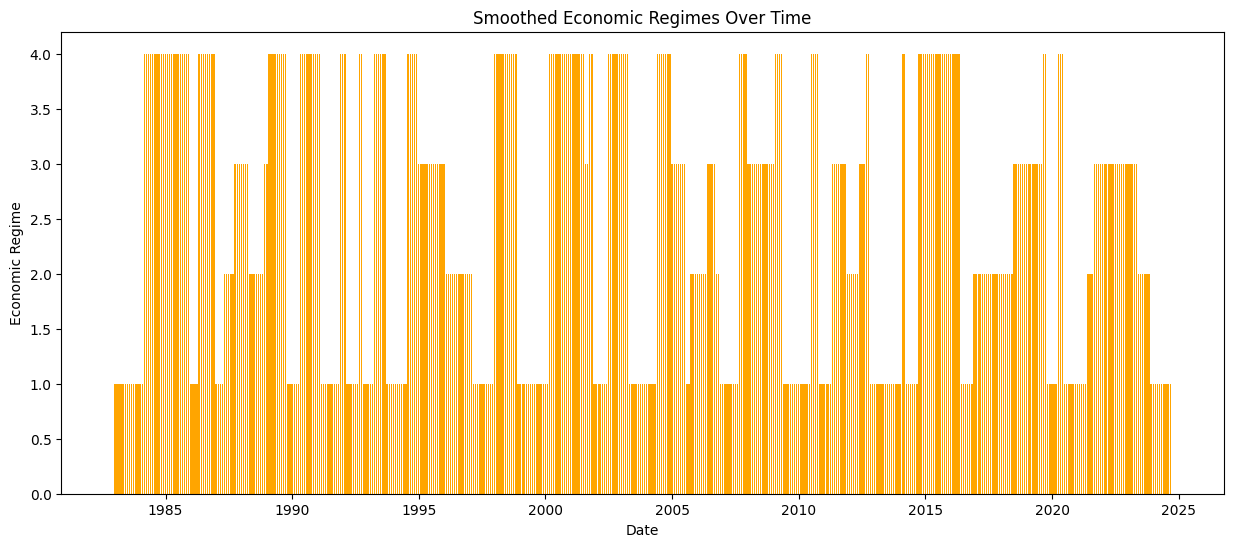

In [14]:
# Load the macro regime data
# Load the uploaded CSV file
file_path = "OECD_Macro.csv"
data_regime = pd.read_csv(file_path)

# Clean the data by dropping rows with any missing values
cleaned_data = data_regime.dropna()

# Convert the 'Date' column to datetime
cleaned_data['Date'] = pd.to_datetime(cleaned_data['Date'], errors='coerce')
cleaned_data = cleaned_data.dropna(subset=['Date'])

# Set the 'Date' column as the index for easier plotting
cleaned_data.set_index('Date', inplace=True)

# Combine the individual regime columns into one with corresponding labels
regime_data = cleaned_data[['1-Goldilocks', '2-Heatingup', '3-Stagflation', '4-Slowgrowth']].idxmax(axis=1)
regime_data = regime_data.str.extract('(\d)-')[0].astype(int)  # Extract regime numbers

# Apply a rolling window with mode to smooth the regime transitions
smoothed_regime_data = (
    regime_data.rolling(window=3, min_periods=1)  # 3-month rolling window
    .apply(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[-1], raw=False)
)

# Plot the smoothed bar chart of regimes over time
fig, ax = plt.subplots(figsize=(15, 6))  # Wider figure for better spacing
ax.bar(smoothed_regime_data.index, smoothed_regime_data, width=20, align='center', color='orange')

# Set labels and title
ax.set_ylabel('Economic Regime')
ax.set_xlabel('Date')
ax.set_title('Smoothed Economic Regimes Over Time')

plt.show()


#### Position dataframe construction

In [15]:
months = data['month'].drop_duplicates().sort_values()

In [17]:
# Index
months = data['month'].drop_duplicates().sort_values()

# Columns
all_permnos = data['permno'].unique()

# Use the index and columns above to initialize an empty position dataframe
position_df = pd.DataFrame(index=months, columns=all_permnos).fillna(0)

# Individual stock tracking dataframe (a helper dataframe to track the holding period of each individual stock)
current_holdings = pd.DataFrame(columns=['permno', 'entry_month'])

# Position dataframe construction
for i, current_month in enumerate(months):
    # Remove stocks that have completed their 2-month holding period
    two_months_ago = current_month - pd.offsets.MonthEnd(2)
    holdings_to_remove = current_holdings[current_holdings['entry_month'] == two_months_ago]
    current_holdings = current_holdings[~current_holdings['permno'].isin(holdings_to_remove['permno'])]

    # Calculate current number of holdings
    current_holdings_count = len(current_holdings)

    # Determine the number of new stocks to add
    if i == 0:
        # Initial portfolio
        max_new_stocks_allowed = 50
    else:
        max_new_stocks_allowed = 25

    # Ensure total holdings stay within 50 and 100 stocks
    num_new_stocks = max(max(50 - current_holdings_count, 0), max_new_stocks_allowed)
    max_additional_stocks = 100 - current_holdings_count
    num_new_stocks = min(num_new_stocks, max_additional_stocks)

    if num_new_stocks > 0:
        # Get data for the current month
        month_data = data[data['month'] == current_month]

        # Exclude stocks already in holdings
        month_data = month_data[~month_data['permno'].isin(current_holdings['permno'])]

        if smoothed_regime_data[current_month] in [1, 2]:
            # Select stocks with positive momentum
            positive_mom_stocks = month_data[month_data['ret_12_1'] > 0]

            if len(positive_mom_stocks) >= 2*num_new_stocks:
                # Select top stocks with highest momentum
                selected_stocks_sub = positive_mom_stocks.nlargest(2*num_new_stocks, 'ret_12_1')
                selected_stocks = selected_stocks_sub.nlargest(num_new_stocks, 'diff')
            else:
                # Select all stocks with positive momentum
                selected_stocks_sub = positive_mom_stocks
                num_needed = num_new_stocks - len(selected_stocks_sub)
                # Select additional stocks with highest 'diff' if needed
                remaining_stocks = month_data[~month_data['permno'].isin(selected_stocks_sub['permno'])]
                top_estimate_stocks = remaining_stocks.nlargest(num_needed, 'diff')
                selected_stocks_sub = pd.concat([selected_stocks_sub, top_estimate_stocks])
                selected_stocks = selected_stocks_sub.nlargest(num_new_stocks, 'diff')


            # Add selected stocks to current holdings
            new_holdings = pd.DataFrame({
                'permno': selected_stocks['permno'],
                'entry_month': current_month
            })
            current_holdings = pd.concat([current_holdings, new_holdings], ignore_index=True)
            
        elif smoothed_regime_data[current_month] == 3:
            # Select stocks with positive momentum
            positive_roe_stocks = month_data[month_data['ni_be'] > 0]

            if len(positive_roe_stocks) >= 2*num_new_stocks:
                # Select top stocks with highest roe
                selected_stocks_sub = positive_roe_stocks.nlargest(2*num_new_stocks, 'ni_be')
                selected_stocks_sub_sub = positive_roe_stocks.nlargest(int(1.5 * num_new_stocks), 'ret_12_1')
                selected_stocks = selected_stocks_sub.nlargest(num_new_stocks, 'diff')
            else:
                # Select all stocks with positive roe
                selected_stocks_sub = positive_roe_stocks
                num_needed = num_new_stocks - len(selected_stocks_sub)
                # Select additional stocks with highest 'Estimate' if needed
                remaining_stocks = month_data[~month_data['permno'].isin(selected_stocks_sub['permno'])]
                top_estimate_stocks = remaining_stocks.nlargest(num_needed, 'ret_12_1')
                selected_stocks_sub = pd.concat([selected_stocks_sub, top_estimate_stocks])
                selected_stocks = selected_stocks_sub.nlargest(num_new_stocks, 'diff')
        
            # Add selected stocks to current holdings
            new_holdings = pd.DataFrame({
                'permno': selected_stocks['permno'],
                'entry_month': current_month
            })
            current_holdings = pd.concat([current_holdings, new_holdings], ignore_index=True)
        else:
            # Select stocks with positive momentum
            positive_roe_stocks = month_data[month_data['ni_be'] > 0]

            if len(positive_roe_stocks) >= 2*num_new_stocks:
                # Select top stocks with highest roe
                selected_stocks_sub = positive_roe_stocks.nlargest(2*num_new_stocks, 'ni_be')
                selected_stocks = selected_stocks_sub.nlargest(num_new_stocks, 'diff')
            else:
                # Select all stocks with positive roe
                selected_stocks_sub = positive_roe_stocks
                num_needed = num_new_stocks - len(selected_stocks_sub)
                # Select additional stocks with highest 'Estimate' if needed
                remaining_stocks = month_data[~month_data['permno'].isin(selected_stocks_sub['permno'])]
                top_estimate_stocks = remaining_stocks.nlargest(num_needed, 'diff')
                selected_stocks_sub = pd.concat([selected_stocks_sub, top_estimate_stocks])
                selected_stocks = selected_stocks_sub.nlargest(num_new_stocks, 'diff')
        
            # Add selected stocks to current holdings
            new_holdings = pd.DataFrame({
                'permno': selected_stocks['permno'],
                'entry_month': current_month
            })
            current_holdings = pd.concat([current_holdings, new_holdings], ignore_index=True)

    # Update the portfolio holdings for the current month
    position_df.loc[current_month, current_holdings['permno']] = 1

# Replace any NaN values with 0
position_df = position_df.fillna(0)

# Number of stocks in the porfolio each month
position_df['num_stocks'] = position_df.sum(axis=1)

# print the position dataframe
position_df


,81912,80303,84584,80361,80266,80191,80286,80204,76697,80079,...,86822,92601,75860,50606,21415,18835,21895,23439,15909,num_stocks
month,,,,,,,,,,,,,,,,,,,,,
2010-01-31,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,50
2010-02-28,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,75
2010-03-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,50
2010-04-30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,50
2010-05-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,50
2023-09-30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,50
2023-10-31,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,50


#### 50~100 position checking

In [18]:
# Check if < 50
position_df[position_df['num_stocks'] < 50]

,81912,80303,84584,80361,80266,80191,80286,80204,76697,80079,...,86822,92601,75860,50606,21415,18835,21895,23439,15909,num_stocks
month,,,,,,,,,,,,,,,,,,,,,


In [19]:
# Check if > 100
position_df[position_df['num_stocks'] > 100]

,81912,80303,84584,80361,80266,80191,80286,80204,76697,80079,...,86822,92601,75860,50606,21415,18835,21895,23439,15909,num_stocks
month,,,,,,,,,,,,,,,,,,,,,


#### Top 10 holdings

In [20]:
# Top 10 holdings
position_df.sum().sort_values(ascending=False).head(11)

num_stocks    8425
80320           68
29946           58
57665           56
11618           56
61313           54
17144           54
65307           52
82777           50
10104           50
85914           48
dtype: int64

#### Cumulative Return

In [21]:
# Melt the position DataFrame to have one row per stock per month
position_melted = position_df.reset_index().melt(id_vars=['month'], var_name="permno", value_name="position")

# Filter for rows where the position is held (value is 1)
position_melted = position_melted[position_melted["position"] == 1]

# Convert permno to integer for proper merging
position_melted['permno'] = position_melted['permno'].astype(int)

# Merge position data with excess return data
merged_df = pd.merge(position_melted, er_df, left_on=['month', 'permno'], right_on=['date', 'permno'])

# Group by month and calculate the equal-weighted portfolio return
portfolio_return = merged_df.groupby('month')['stock_exret'].mean().reset_index(name='equal_weighted_return')

# Cumulative return
portfolio_return['cumulative_return'] = (1 + portfolio_return['equal_weighted_return']).cumprod()

# Rebase so that the first month starts at 100
portfolio_return['cumulative_return'] = portfolio_return['cumulative_return'] / portfolio_return['cumulative_return'].iloc[0] * 100
portfolio_return

,month,equal_weighted_return,cumulative_return
0,2010-01-31,-0.045117,100.000000
1,2010-02-28,0.059209,105.920854
2,2010-03-31,0.072763,113.627959
3,2010-04-30,0.052625,119.607663
4,2010-05-31,-0.080227,110.011871
...,...,...,...
163,2023-08-31,-0.033653,468.679641
164,2023-09-30,-0.067344,437.117064
165,2023-10-31,-0.075068,404.303485
166,2023-11-30,0.114739,450.692694


### Performance Comparison

#### Data loading and cleaning

In [22]:
### Load the SP500 dataset as benchmark
sp500_df = yf.download('^SPX',start='2009-01-01', end='2024-02-02' )
sp500_df = sp500_df[['Close']]
#sp500_df['Date'] = pd.to_datetime(sp500_df['Date'])
#sp500_df.set_index('Date', inplace=True)
sp500_monthly = sp500_df.resample('M').last()
sp500_monthly['monthly_return'] = sp500_monthly['Close'].pct_change()
sp500_monthly = sp500_monthly.dropna()
sp500_monthly

[*********************100%***********************]  1 of 1 completed


,Close,monthly_return
Date,,
2009-02-28,735.090027,-0.109931
2009-03-31,797.869995,0.085404
2009-04-30,872.809998,0.093925
2009-05-31,919.140015,0.053081
2009-06-30,919.320007,0.000196
...,...,...
2023-10-31,4193.799805,-0.021980
2023-11-30,4567.799805,0.089179
2023-12-31,4769.830078,0.044229


In [23]:
### Merge the SP500 benchmark to the portfolio return dataset
df_unique_dates = er_df.drop_duplicates(subset='date', keep='first').reset_index(drop=True)
df_unique_dates = df_unique_dates[df_unique_dates['date'].between('2010-01-31', '2023-12-31')].reset_index(drop=True)
df_unique_dates
merged_df = pd.merge(portfolio_return, sp500_monthly[['monthly_return']], left_on='month', right_on='Date', how='left')
merged_df = merged_df.dropna()
merged_df['monthly_excess_return'] = merged_df['monthly_return'] - df_unique_dates['rf']
merged_df['sp500_cumulative_return'] = (1 + merged_df['monthly_excess_return']).cumprod()
merged_df['sp500_cumulative_return'] = merged_df['sp500_cumulative_return'] / merged_df['sp500_cumulative_return'].iloc[0] * 100
merged_df

,month,equal_weighted_return,cumulative_return,monthly_return,monthly_excess_return,sp500_cumulative_return
0,2010-01-31,-0.045117,100.000000,-0.036974,-0.036974,100.000000
1,2010-02-28,0.059209,105.920854,0.028514,0.028514,102.851369
2,2010-03-31,0.072763,113.627959,0.058796,0.058696,108.888377
3,2010-04-30,0.052625,119.607663,0.014759,0.014659,110.484596
4,2010-05-31,-0.080227,110.011871,-0.081976,-0.082076,101.416480
...,...,...,...,...,...,...
163,2023-08-31,-0.033653,468.679641,-0.017716,-0.022216,379.598124
164,2023-09-30,-0.067344,437.117064,-0.048719,-0.053019,359.472071
165,2023-10-31,-0.075068,404.303485,-0.021980,-0.026680,349.881468
166,2023-11-30,0.114739,450.692694,0.089179,0.084779,379.544163


#### Evaluation metrics for EPS surprise enhanced momentum strategy

In [24]:
### Evaluation of EPS surprise enhanced momentum strategy
sharpe = (
    merged_df["equal_weighted_return"].mean() / merged_df["equal_weighted_return"].std() * np.sqrt(12)
)  # Sharpe ratio is annualized
print("Sharpe Ratio:", sharpe)

# Newy-West regression for heteroskedasticity and autocorrelation robust standard errors
nw_ols = sm.ols(formula="equal_weighted_return ~ monthly_excess_return", data=merged_df[['equal_weighted_return', 'monthly_excess_return']]).fit(
    cov_type="HAC", cov_kwds={"maxlags": 3}, use_t=True
)
#print(nw_ols.summary())

# Alpha, t-statistic, and Information ratio:
print("CAPM Annualized Alpha:", nw_ols.params["Intercept"] * 12)
print("t-statistic:", nw_ols.tvalues["Intercept"])
print(
    "Information Ratio:",
    nw_ols.params["Intercept"] / np.sqrt(nw_ols.mse_resid) * np.sqrt(12),
)

# Max 1-month Loss
max_1m_loss = merged_df["equal_weighted_return"].min()
print("Max 1-Month Loss:", max_1m_loss)

# Max Drawdown
merged_df["log_port_11"] = np.log(
    merged_df["equal_weighted_return"] + 1
)  
merged_df["cumsum_log_port_11"] = merged_df["log_port_11"].cumsum(
    axis=0
) 
rolling_peak = merged_df["cumsum_log_port_11"].cummax()
drawdowns = rolling_peak - merged_df["cumsum_log_port_11"]
max_drawdown = drawdowns.max()
print("Maximum Drawdown:", max_drawdown)

# Annualized Excess Return
mean_monthly_return = merged_df[['equal_weighted_return', 'monthly_excess_return']].mean()
monthly_std_dev = merged_df[['equal_weighted_return', 'monthly_excess_return']].std()
annualized_return = (1 + mean_monthly_return)**12 - 1
print('Annualized Return:', annualized_return[0])
print('Benchmark Annualized Return:', annualized_return[1])

# Annualized std_dev
annualized_std_dev = monthly_std_dev * np.sqrt(12)
print('Annualized std_dev:', annualized_std_dev[0])
print('Benchmark Annualized std_dev:', annualized_std_dev[1])

# Turnover
temp_df = position_df.reset_index()
temp_df['month'] = pd.to_datetime(temp_df['month'])
temp_df['year'] = temp_df['month'].dt.year
position_changes = temp_df.drop(columns=['num_stocks','month','year']).diff().abs()
position_changes['year'] = temp_df['year']
annual_traded_volume = position_changes.groupby('year').sum().sum(axis=1)
average_portfolio_size = temp_df.groupby('year')['num_stocks'].mean()
annual_turnover = (annual_traded_volume * 100 / (2 * average_portfolio_size)).reset_index()
annual_turnover.columns = ['year', 'annual_turnover_%']
print('Annual Turnover:', annual_turnover['annual_turnover_%'].mean())

Sharpe Ratio: 0.7062109800819327
CAPM Annualized Alpha: 0.011630834644634498
t-statistic: 0.5015710484200256
Information Ratio: 0.14266942976747343
Max 1-Month Loss: -0.18094574061399998
Maximum Drawdown: 0.42289733447017297
Annualized Return: 0.13397241988475894
Benchmark Annualized Return: 0.11210279850023297
Annualized std_dev: 0.17896610097987903
Benchmark Annualized std_dev: 0.14828432716400913
Annual Turnover: 582.1828571428571


#### Evaluation metrics for EPS surprise enhanced momentum strategy

In [25]:
# Momentum only
# Index
months = data['month'].drop_duplicates().sort_values()

# Columns
all_permnos = data['permno'].unique()

# Use the index and columns above to initialize an empty position dataframe
position_df_compare = pd.DataFrame(index=months, columns=all_permnos).fillna(0)

# Individual stock tracking dataframe (a helper dataframe to track the holding period of each individual stock)
current_holdings = pd.DataFrame(columns=['permno', 'entry_month'])

# Position dataframe construction
for i, current_month in enumerate(months):
    # Remove stocks that have completed their 2-month holding period
    two_months_ago = current_month - pd.offsets.MonthEnd(2)
    holdings_to_remove = current_holdings[current_holdings['entry_month'] == two_months_ago]
    current_holdings = current_holdings[~current_holdings['permno'].isin(holdings_to_remove['permno'])]

    # Calculate current number of holdings
    current_holdings_count = len(current_holdings)

    # Determine the number of new stocks to add
    if i == 0:
        # Initial portfolio
        max_new_stocks_allowed = 50
    else:
        max_new_stocks_allowed = 25

    # Ensure total holdings stay within 50 and 100 stocks
    num_new_stocks = max(max(50 - current_holdings_count, 0), max_new_stocks_allowed)
    max_additional_stocks = 100 - current_holdings_count
    num_new_stocks = min(num_new_stocks, max_additional_stocks)

    if num_new_stocks > 0:
        # Get data for the current month
        month_data = data[data['month'] == current_month]

        # Exclude stocks already in holdings
        month_data = month_data[~month_data['permno'].isin(current_holdings['permno'])]

        # Select stocks with positive 'diff'
        positive_diff_stocks = month_data[month_data['ret_12_1'] > 0]

        if len(positive_diff_stocks) >= num_new_stocks:
            # Select top stocks with highest 'diff'
            selected_stocks = positive_diff_stocks.nlargest(num_new_stocks, 'ret_12_1')
        else:
            # Select all stocks with positive 'diff'
            selected_stocks = positive_diff_stocks
            num_needed = num_new_stocks - len(selected_stocks)
            # Select additional stocks with highest 'Estimate' if needed
            remaining_stocks = month_data[~month_data['permno'].isin(selected_stocks['permno'])]
            top_estimate_stocks = remaining_stocks.nlargest(num_needed, 'diff')
            selected_stocks = pd.concat([selected_stocks, top_estimate_stocks])

        # Add selected stocks to current holdings
        new_holdings = pd.DataFrame({
            'permno': selected_stocks['permno'],
            'entry_month': current_month
        })
        current_holdings = pd.concat([current_holdings, new_holdings], ignore_index=True)

    # Update the portfolio holdings for the current month
    position_df_compare.loc[current_month, current_holdings['permno']] = 1

# Replace any NaN values with 0
position_df_compare = position_df_compare.fillna(0)

position_df_compare['num_stocks'] = position_df_compare.sum(axis=1)

# Melt the position DataFrame to have one row per stock per month
position_melted_compare = position_df_compare.reset_index().melt(id_vars=['month'], var_name="permno", value_name="position")

# Filter for rows where the position is held (value is 1)
position_melted_compare = position_melted_compare[position_melted_compare["position"] == 1]

# Convert permno to integer for proper merging
position_melted_compare['permno'] = position_melted_compare['permno'].astype(int)

# Merge position data with excess return data
merged_df_compare = pd.merge(position_melted_compare, er_df, left_on=['month', 'permno'], right_on=['date', 'permno'])

# Group by month and calculate the equal-weighted portfolio return
portfolio_return_compare = merged_df_compare.groupby('month')['stock_exret'].mean().reset_index(name='equal_weighted_return')

portfolio_return_compare['cumulative_return'] = (1 + portfolio_return_compare['equal_weighted_return']).cumprod()

# Rebase so that the first month starts at 100
portfolio_return_compare['cumulative_return'] = portfolio_return_compare['cumulative_return'] / portfolio_return_compare['cumulative_return'].iloc[0] * 100

# Evaluation
merged_df_compare = pd.merge(portfolio_return_compare, sp500_monthly[['monthly_return']], left_on='month', right_on='Date', how='left')
merged_df_compare = merged_df_compare.dropna()
merged_df_compare['monthly_excess_return'] = merged_df_compare['monthly_return'] - df_unique_dates['rf']
merged_df_compare['sp500_cumulative_return'] = (1 + merged_df_compare['monthly_excess_return']).cumprod()
merged_df_compare['sp500_cumulative_return'] = merged_df_compare['sp500_cumulative_return'] / merged_df_compare['sp500_cumulative_return'].iloc[0] * 100

sharpe = (
    merged_df_compare["equal_weighted_return"].mean() / merged_df_compare["equal_weighted_return"].std() * np.sqrt(12)
)  # Sharpe ratio is annualized
print("Sharpe Ratio:", sharpe)

# Newy-West regression for heteroskedasticity and autocorrelation robust standard errors
nw_ols = sm.ols(formula="equal_weighted_return ~ monthly_excess_return", data=merged_df_compare[['equal_weighted_return', 'monthly_excess_return']]).fit(
    cov_type="HAC", cov_kwds={"maxlags": 3}, use_t=True
)
#print(nw_ols.summary())

# Alpha, t-statistic, and Information ratio:
print("CAPM Annualized Alpha:", nw_ols.params["Intercept"] * 12)
print("t-statistic:", nw_ols.tvalues["Intercept"])
print(
    "Information Ratio:",
    nw_ols.params["Intercept"] / np.sqrt(nw_ols.mse_resid) * np.sqrt(12),
)

# Max 1-month drawdone
max_1m_loss = merged_df_compare["equal_weighted_return"].min()
print("Max 1-Month Loss:", max_1m_loss)

# Max Drawdown
merged_df_compare["log_port_11"] = np.log(
    merged_df_compare["equal_weighted_return"] + 1
)
merged_df_compare["cumsum_log_port_11"] = merged_df_compare["log_port_11"].cumsum(
    axis=0
)
rolling_peak = merged_df_compare["cumsum_log_port_11"].cummax()
drawdowns = rolling_peak - merged_df_compare["cumsum_log_port_11"]
max_drawdown = drawdowns.max()
print("Maximum Drawdown:", max_drawdown)

# Annualized Return
mean_monthly_return = merged_df_compare[['equal_weighted_return', 'monthly_excess_return']].mean()
monthly_std_dev = merged_df_compare[['equal_weighted_return', 'monthly_excess_return']].std()
annualized_return = (1 + mean_monthly_return)**12 - 1
print('Annualized Return:', annualized_return[0])

# Annualized std_dev
annualized_std_dev = monthly_std_dev * np.sqrt(12)
print('Annualized std_dev:', annualized_std_dev[0])

# Turnover
temp_df = position_df_compare.reset_index()
temp_df['month'] = pd.to_datetime(temp_df['month'])
temp_df['year'] = temp_df['month'].dt.year
position_changes = temp_df.drop(columns=['num_stocks','month','year']).diff().abs()
position_changes['year'] = temp_df['year']
annual_traded_volume = position_changes.groupby('year').sum().sum(axis=1)
average_portfolio_size = temp_df.groupby('year')['num_stocks'].mean()
annual_turnover = (annual_traded_volume * 100 / (2 * average_portfolio_size)).reset_index()
annual_turnover.columns = ['year', 'annual_turnover_%']
print('Annual Turnover:', annual_turnover['annual_turnover_%'].mean())


Sharpe Ratio: 0.6371443148762438
CAPM Annualized Alpha: 0.0038080306630837763
t-statistic: 0.14155710432785135
Information Ratio: 0.03774970363115532
Max 1-Month Loss: -0.20340807158000002
Maximum Drawdown: 0.3511291002644398
Annualized Return: 0.13225724422418828
Annualized std_dev: 0.1959654887199053
Annual Turnover: 570.0571428571428


#### Visualization

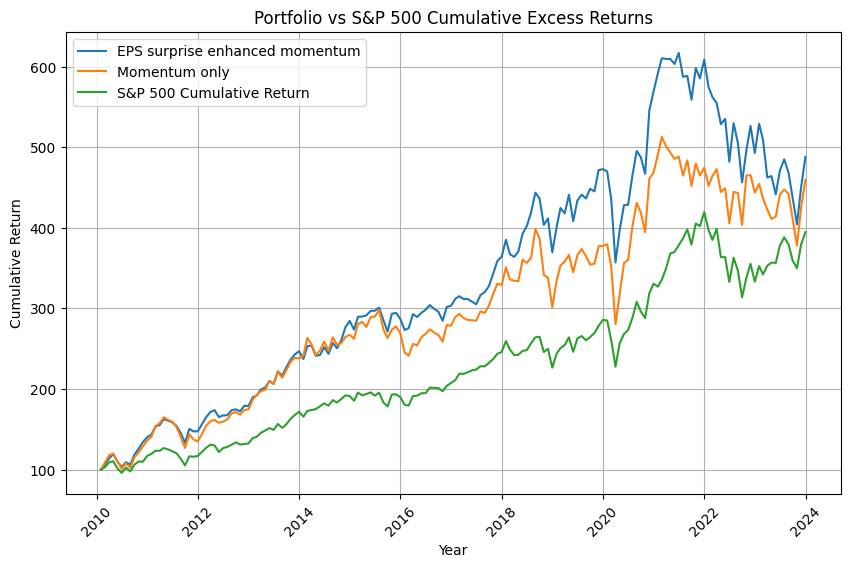

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(merged_df['month'], merged_df['cumulative_return'], linestyle='-', label='EPS surprise enhanced momentum')
plt.plot(portfolio_return_compare['month'], portfolio_return_compare['cumulative_return'], linestyle='-', label='Momentum only')
plt.plot(merged_df['month'], merged_df['sp500_cumulative_return'], linestyle='-', label='S&P 500 Cumulative Return')
plt.title('Portfolio vs S&P 500 Cumulative Excess Returns')
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()